# Topic Modeling
## Latent Dirichlet Allocation - LDA
### Building a topic model

In [1]:
import gensim

In [2]:
from gensim import corpora, models

In [3]:
from os import path

Load the data

In [4]:
corpus = corpora.BleiCorpus('./data/ap/ap.dat', './data/ap/vocab.txt')

Build the LDA model

In [5]:
model = models.ldamodel.LdaModel(corpus, num_topics=100, id2word=corpus.id2word)

In [6]:
doc = corpus.docbyoffset(0)
topics = model[doc]
print(topics)

[(2, 0.41156003), (4, 0.02499845), (8, 0.024362054), (16, 0.032788057), (38, 0.067108594), (43, 0.024014268), (48, 0.01602851), (70, 0.019357346), (77, 0.18691927), (81, 0.011917967), (84, 0.012145045), (86, 0.06627487), (92, 0.091026135)]


Plotting a histogram of the number of topics that each document refers to:

In [7]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Number of topics')

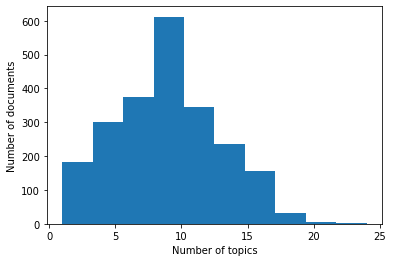

In [8]:
num_topics_used = [len(model[doc]) for doc in corpus]
fig,ax = plt.subplots()
ax.hist(num_topics_used)
ax.set_ylabel('Number of documents')
ax.set_xlabel('Number of topics')

In [9]:
model1 = models.ldamodel.LdaModel(corpus, num_topics=100, id2word=corpus.id2word, alpha=1)

Text(40, 300, 'alpha=1.0')

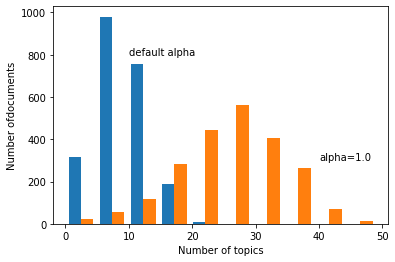

In [10]:
num_topics_used1 = [len(model1[doc]) for doc in corpus]
fig,ax = plt.subplots()
ax.hist([num_topics_used, num_topics_used1])
ax.set_ylabel('Number ofdocuments')
ax.set_xlabel('Number of topics')
ax.text(10, 800, 'default alpha')
ax.text(40, 300, 'alpha=1.0')

In [11]:
from gensim import matutils
import numpy as np

In [12]:
topics = matutils.corpus2dense(model[corpus], num_terms=model.num_topics)

Filtering out stop words:

In [13]:
import nltk.stem

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
english_stemmer = nltk.stem.SnowballStemmer('english')
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords.update(['from:', 'subject:', 'writes:', 'writes'])

In [16]:
# Adaptor class
class DirectText(corpora.textcorpus.TextCorpus):
    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

Load the data

In [17]:
import sklearn.datasets

In [18]:
dataset = sklearn.datasets.fetch_20newsgroups("20news-18828", "train")

c:\users\praab\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass data_home=20news-18828, subset=train as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Preprocessing the data to split the data into words and remove stopwords:

In [19]:
otexts = dataset.data
texts = dataset.data

texts = [t.split() for t in texts]
texts = [map(lambda w: w.lower(), t) for t in texts]
texts = [filter(lambda s: not len(set("+-.?!()>@012345689") & set(s)), t) for t in texts]
texts = [filter(lambda s: (len(s) > 3) and (s not in stopwords), t) for t in texts]
texts = [[english_stemmer.stem(w) for w in t] for t in texts]

Removing words that are too common:

In [20]:
from collections import defaultdict
usage = defaultdict(int)
for t in texts:
    for w in set(t):
        usage[w] += 1
limit = len(texts) / 10
too_common = [w for w in usage if usage[w] > limit]
too_common = set(too_common)
texts = [[w for w in t if w not in too_common] for t in texts]

In [21]:
corpus = DirectText(texts)
dictionary = corpus.dictionary
try:
    dictionary['computer']
except:
    pass

model = models.ldamodel.LdaModel(
    corpus, num_topics=100, id2word=dictionary.id2token)

thetas = np.zeros((len(texts), 100))
for i, c in enumerate(corpus):
    for ti, v in model[c]:
        thetas[i, ti] += v

### Comparing documents by topics
Computing all pairwise distances using pdist function in SciPy

In [22]:
from scipy.spatial import distance

In [23]:
pairwise = distance.squareform(distance.pdist(thetas))
# Set the diagonal elements of the distance matrix to a high value
largest = pairwise.max()
for ti in range(len(pairwise)):
    pairwise[ti, ti] = largest+1

In [24]:
def closest_to(doc_id):
    return pairwise[doc_id].argmin()

Possible query document:

In [25]:
print(otexts[1])

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock reports
Keywords: SI,acceleration,clock,upgrade
Article-I.D.: shelley.1qvfo9INNc3s
Organization: University of Washington
Lines: 11
NNTP-Posting-Host: carson.u.washington.edu

A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the next two days, so please add to the network
knowledge base if you have done the clock upgrade and haven't answered this
poll. Thanks.

Guy Kuo <guykuo@u.washington.edu>



If we ask for the most similar document to closest_to(1), we receive the following document as a result:

In [26]:
print(otexts[closest_to(1)])

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI clock reports
Summary: Request for SI clock poll
Keywords: SI,clock,upgrade,oscillator,chip
Article-I.D.: shelley.1qokppINNree
Organization: University of Washington
Lines: 18
NNTP-Posting-Host: carson.u.washington.edu

I am continuing to collect user results to produce a more comprehensive
report on IIsi clock oscillator upgrades. I you have attempted the modification
please drop me a note with details of your experience. The more reports 
obtained, the more accurate the numbers I will generate.

If possible, please include the following:
  1) Top speed achieved
  2) System configuration at top Mhz setting
       a) speed rating of the CPU (the last two digits printed on CPU #)
       b) presence of additional heat sinks
       c) Nubus & FPU cards used
       d) floppy drive functionality on both 800 and 1.4 M disks
  3) Damage incurred during modification
  4) Damage due to higher speed use
  5) Average length of time the CP

### The system returns a post by the same author discussing SI clock.